# Refresh FAOSTAT data in Datamart

In [1]:
import sys
sys.path.append("../")

import io, glob
import pandas as pd
from utils import frame, ops
from requests import get,post,put,delete
from IPython.display import display, HTML

## All parameters are passed from commandline

In [2]:
# Parameters to be injected
template_path = 'FAOSTAT_template.tsv'
datasets_path = './datasets'
datamart_api_url = 'http://localhost:12543'
dataset_to_erase = None

### Remove datasets when needed

In [7]:
if not dataset_to_erase is None:
    ops.erase_dataset(datamart_api_url, dataset_to_erase)

### Load template into memory

In [8]:
df_template = frame.get_template(template_path)
df_template

,0,1,2,3,4,5,6,7,8,9,10,11
0,dataset,FAOSTAT,FAO Fertilizers by Product,The Fertilizers by Product dataset contains in...,http://www.fao.org/faostat/en/#data/RFB,,,,,,,
1,role,qualifier,location,qualifier,main subject,qualifier,qualifier,,time,unit,variable,qualifier
2,type,string,country,string,string,string,string,,year,string,number,string
3,description,,,,,,,,,,,
4,name,,,,,,,,,,,
5,unit,,,,,,,,,,,
6,header,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
7,data,,,,,,,,,,,


### Build the pattern of files to be uploaded

In [9]:
patterns = ops.generate_targets(datasets_path)

### Build the sheet to be uploaded

In [10]:
dataset_id = df_template.iloc[0,1]

# This sheet holds all the datapoints to be uploaded
annotated_sheet = frame.get_template(template_path)
add_datatag = True

for p in patterns:
    for filename in glob.iglob(p):        
        annotated_sheet, add_datatag = frame.append_sheet(annotated_sheet, filename, add_datatag)

### Post the annotated sheet to datamart

In [12]:
frame.upload_annotated_sheet(annotated_sheet, dataset_id, datamart_api_url)

### Check the data has been uploaded

In [13]:
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
dataset_id = 'FAOSTAT'
q_variable = 'value'
response = get(f'{datamart_api_url}/datasets/{dataset_id}/variables/{q_variable}')
df = pd.read_csv(io.StringIO(response.text))

In [15]:
# Select 'PK compounds'
z = df[df['Item Code'] == 4027]
# Select 'Production'
z = z[z['Element Code'] == 5510]

z = pd.concat([z['value'], z['time'].apply(lambda t: datetime.strptime(t,'%Y-%m-%dT%H:%M:%SZ').year)], axis=1)
z.columns = ['value', 'year']
z = z[['value','year']].groupby(['year']).sum()

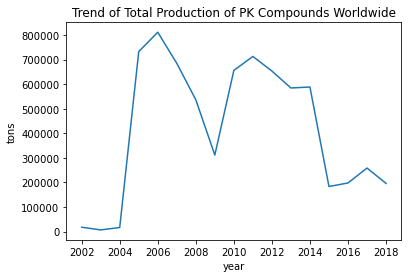

In [16]:
fig, ax = plt.subplots()
ax.plot(z.index,z['value'])

ax.set(xlabel='year', ylabel='tons', title=f'Trend of Total Production of PK Compounds Worldwide')
plt.show()